GitHub: https://github.com/MYUSER/MYPROJECT/


Welcome to your assignment this week! 

To better understand the adverse use of AI, in this assignment, we will look at a Natural Language Processing use case.


Natural Language Pocessing (NLP) is a branch of Artificial Intelligence (AI) that helps computers to understand, to interpret and to manipulate natural (i.e. human) language.
Imagine NLP-powered machines as black boxes that are capable of understanding and evaluating the context of the input documents (i.e. collection of words), outputting meaningful results that depend on the task the machine is designed for.


![](imgs/1_3zMvUnPzYZF9CSHdj6hT5A.png)

<caption><center> Documents are fed into magic NLP model capable to get, for instance, the sentiment of the original content</center></caption>


In this notebook, you will implement a model that uses an LSTM to generate fake tweets and comments. You will also be able to try it to generate your own fake text. 

**You will learn to:**
- Apply an LSTM to generate fake comments.
- Generate your own fake text with deep learning.

Please run the following cell to load all the packages required in this assignment. This may take a few minutes. 


In [1]:
#!pip install numpy
#!pip install keras
#!pip install tensorflow

Run the following cell to load the packages you will need.

In [2]:
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Build the model

Let's define a tokenizer and read the data from disk.

In [3]:
tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
data = open('covid19_fake.txt').read().replace(".", " . ").replace(",", " , ").replace("?", " ? ").replace("!", " ! ")

Now, let's splits the data into tweets  where each line of the input file is a fake tweets.

We also extract the vocabulary of the data.

In [4]:
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

You've loaded:
- `corpus`: an array where each entry is a fake post.
- `tokenizer`: which is the object that we will use to vectorize our dataset. This object also contains our word index.
- `total_words`: is the total number of words in the vacabulary.


In [5]:
print("Example of fake tweets: ",corpus[:2])
print("Size of the vocabulary = ", total_words)
index = [(k, v) for k, v in tokenizer.word_index.items()]
print("Example of our word index = ", index[0:10])

Example of fake tweets:  ['there is already a vaccine to treat covid19 . ', 'cleaning hands do not help to prevent covid19 . ']
Size of the vocabulary =  1257
Example of our word index =  [('.', 1), ('the', 2), ('covid19', 3), ('in', 4), ('to', 5), ('a', 6), ('of', 7), (',', 8), ('coronavirus', 9), ('and', 10)]


The next step aims to generate the training set of n_grams sequences.

In [6]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

You've create:
- `input_sequences`: which is a list of n_grams sequences.

In [7]:
sample = 20
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
for i in input_sequences[sample]:
    print(reverse_word_map[i], end=' ')
                        

The entry  20  in 'input_sequences' is: 
[2, 3, 12, 187, 34, 188]
 and it corresponds to:
the covid19 is same as sars 

Next, we padd our training set to the max length in order to be able to make a batch processing.

In [8]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Run the following to see the containt of the padded 'input_sequences' object.

In [9]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
print("[", end=' ')
for i in input_sequences[sample]:
    if i in reverse_word_map:
        print(reverse_word_map[i], end=' ')
    else:
        print("__", end=' ')
print("]")
                

The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
 and it corresponds to:
[ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ the covid19 is same as sars ]


Given a sentence like **"the covid19 is same as "**, we want to design a model that can predict the next word -- in the case the word **"sars"**.

Therefore, the next code prepares our input and output to our model consequently.

In [10]:
input_to_model, label = input_sequences[:,:-1],input_sequences[:,-1]
label_2 = label

In [11]:
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(", it corresponds to the following input to our model:")
print(input_to_model[sample])
print(" and the following output: ", label[sample])


The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
, it corresponds to the following input to our model:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34]
 and the following output:  188


Finally, we convert our label to categorical labels for being processed by our model.

In [12]:
label = ku.to_categorical(label, num_classes=total_words)

Here is the architecture of the model we will use:

![](imgs/text_generation.png)



 
**Task 1**: Implement `deep_fake_comment_model()`. You will need to carry out 5 steps:

1. Create a sequencial model using the `Sequential` class
2. Add an embedding layer to the model using the `Embedding` class of size 128
3. Add an LSTM layer to the model using the `LSTM` class of size 128
4. Add a Dense layer to the model using the `Dense` class with a `softmax` activation
5. Set a `categorical_crossentropy` loss function to the model and optimize `accuracy`.


In [13]:
#TASK 1
# deep_fake_comment_model

def deep_fake_comment_model():
    model = Sequential()
    model.add(Embedding(input_dim = total_words, output_dim = 128,input_length=len(input_to_model[0]), name='Embedding'))
    model.add(LSTM(units=128, name = 'LSTM'))
    model.add(Dense(units=len(label[0]), activation='softmax'))
    model.compile(Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    
#Print details of the model.
model = deep_fake_comment_model()


Now, let's start our training.

In [14]:
history = model.fit(input_to_model, label, epochs=200, batch_size=32, verbose=1)

Epoch 1/200
126/126 [==============================] - 1s 8ms/step - loss: 6.3722 - accuracy: 0.0660
Epoch 2/200
126/126 [==============================] - 1s 8ms/step - loss: 5.8719 - accuracy: 0.0747
Epoch 3/200
126/126 [==============================] - 1s 8ms/step - loss: 5.7332 - accuracy: 0.0916
Epoch 4/200
126/126 [==============================] - 1s 9ms/step - loss: 5.6106 - accuracy: 0.1082
Epoch 5/200
126/126 [==============================] - 1s 8ms/step - loss: 5.4530 - accuracy: 0.1221
Epoch 6/200
126/126 [==============================] - 1s 8ms/step - loss: 5.2623 - accuracy: 0.1409
Epoch 7/200
126/126 [==============================] - 1s 8ms/step - loss: 5.0536 - accuracy: 0.1556
Epoch 8/200
126/126 [==============================] - 1s 9ms/step - loss: 4.8548 - accuracy: 0.1690
Epoch 9/200
126/126 [==============================] - 1s 9ms/step - loss: 4.6649 - accuracy: 0.1836
Epoch 10/200
126/126 [==============================] - 1s 9ms/step - loss: 4.4809 - accura

126/126 [==============================] - 1s 9ms/step - loss: 0.1713 - accuracy: 0.9484
Epoch 82/200
126/126 [==============================] - 1s 8ms/step - loss: 0.1683 - accuracy: 0.9481
Epoch 83/200
126/126 [==============================] - 1s 9ms/step - loss: 0.1681 - accuracy: 0.9489
Epoch 84/200
126/126 [==============================] - 1s 9ms/step - loss: 0.1652 - accuracy: 0.9494
Epoch 85/200
126/126 [==============================] - 1s 9ms/step - loss: 0.1633 - accuracy: 0.9474
Epoch 86/200
126/126 [==============================] - 1s 9ms/step - loss: 0.1607 - accuracy: 0.9491
Epoch 87/200
126/126 [==============================] - 1s 10ms/step - loss: 0.1613 - accuracy: 0.9474
Epoch 88/200
126/126 [==============================] - 1s 11ms/step - loss: 0.1582 - accuracy: 0.9479
Epoch 89/200
126/126 [==============================] - 1s 10ms/step - loss: 0.1563 - accuracy: 0.9496
Epoch 90/200
126/126 [==============================] - 1s 10ms/step - loss: 0.1552 - accura

126/126 [==============================] - 1s 9ms/step - loss: 0.1276 - accuracy: 0.9486
Epoch 161/200
126/126 [==============================] - 1s 10ms/step - loss: 0.1283 - accuracy: 0.9496
Epoch 162/200
126/126 [==============================] - 1s 9ms/step - loss: 0.1278 - accuracy: 0.9501
Epoch 163/200
126/126 [==============================] - 1s 9ms/step - loss: 0.1271 - accuracy: 0.9511
Epoch 164/200
126/126 [==============================] - 1s 9ms/step - loss: 0.1274 - accuracy: 0.9499
Epoch 165/200
126/126 [==============================] - 1s 9ms/step - loss: 0.1277 - accuracy: 0.9511
Epoch 166/200
126/126 [==============================] - 1s 9ms/step - loss: 0.1274 - accuracy: 0.9501
Epoch 167/200
126/126 [==============================] - 1s 9ms/step - loss: 0.1273 - accuracy: 0.9504
Epoch 168/200
126/126 [==============================] - 1s 10ms/step - loss: 0.1281 - accuracy: 0.9484
Epoch 169/200
126/126 [==============================] - 1s 9ms/step - loss: 0.1273 -

Let's plot details of our training.

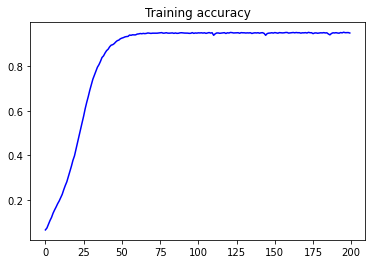

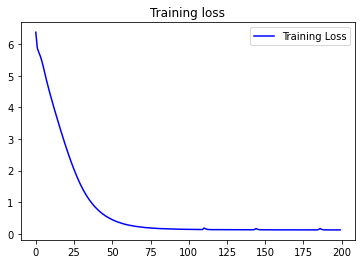

In [15]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

# Generating fake comments

To generate fake tweets, we use the below architecture:

![](imgs/text_gen.png)

The idea is to give one or more starting token(s) to our model, and generate the next tokens until we generate `.`.

At each step, we select the token with the highest probability as our next token and generate the next one similartly using `model.predict_classes()`. 

**Note:** The model takes as input the activation `a` from the previous state of the LSTM and the token chosen, forward propagate by one step, and get a new output activation `a`. The new activation `a` can then be used to generate the output, using the `dense` layer with `softmax` activation as before. 



**Task 2**: Implement `generate()`. 

***

In [16]:
#TASK 2
# Implement the generate() function

def generate(seed_text):
    checker = False
    text = seed_text
    while checker == False:
        a = tokenizer.texts_to_sequences([text])
        a = np.array(pad_sequences(a, maxlen=(max_sequence_len-1), padding='pre'))
        prediction = model.predict_classes(a)
        predicted_word = list(tokenizer.word_index.items())[prediction[0]-1][0]
        
        text = f'{text} {predicted_word}'
        
        if predicted_word == '.' or len(text.split(' ')) == max_sequence_len:
            checker = True
        
    return text
    
    ### END CODE HERE ### 


**Let's test it:**

In [17]:
print(generate("COVID19 virus"))
print(generate("COVID19 is the"))
print(generate("The usa is"))
print(generate("The new virus"))
print(generate("China has"))


W0821 01:10:39.019292 21408 deprecation.py:323] From <ipython-input-16-4481f2724298>:10: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


COVID19 virus survives on surfaces for 7 days .
COVID19 is the deadliest virus known to humans .
The usa is a lot of water and gargling with warm salt water eliminates the covid19 virus .
The new virus known to the covid19 was caused by an accidental leak from wuhan virus research institute .
China has been vaccinating cattle for coronavirus for years , yet the news tells you it's new and gunna kill you all so go buy mask .


**Let's test it in an interactive mode:**

In [18]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: bill gates
bill gates caused the infection of covid19 . 

# Generating text by sampling

The previous part is generating text by choosing the token with the highest probability. Now, we sill generate text by sampling as shown in the architecture below:

![](imgs/text_gen_sample.png)


**TASK 3:** Implement the `generate_sample()` function. To sample a token from the output at each timestep, you need to use the following two functions:
- `model.predict_proba()`: To get probabilities from the output layer.
- `np.random.choice()`: To sample from the token list using the probaility array of each token.

***

In [19]:
#TASK 3
# Implement the generate_sample() function
def generate_sample(seed_text):
   ### START CODE HERE ### 
    checker = False
    text = seed_text
    while checker == False:
        a = tokenizer.texts_to_sequences([text])
        a = np.array(pad_sequences(a, maxlen=(max_sequence_len-1), padding='pre'))
        
        prediction = model.predict_proba(a)[0]
        key_list = list(tokenizer.word_index.keys())
        key_list.insert(0, '')
        rand = np.random.choice(key_list, p = prediction)
        
        text = f'{text} {rand}'
        
        if rand == '.' or len(text.split(' '))==max_sequence_len:
            checker = True
    return text
    ### END CODE HERE ### 

**Let's test it in an interactive mode:**

In [20]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate_sample(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: what could


W0821 01:27:37.827921 21408 deprecation.py:323] From <ipython-input-19-f80541ca1a25>:11: Sequential.predict_proba (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use `model.predict()` instead.


what could transfer covid19 from person to person . 

# Generate your own text 

Below, use you own data to generate content for a different application:

In [21]:
print(generate_sample('Covid19 is likely'))
print(generate_sample("Covid19 can't possibly"))
print(generate_sample('China is going'))
print(generate_sample('russia says that'))
print(generate_sample('watch out for'))

Covid19 is likely just a mutated form of the common cold .
Covid19 can't possibly be transmitted in areas with hot and humid climates .
China is going the us nih in 2017 give 3 .
russia says that if the coronavirus gets in your mouth , drinking water or other liquids will wash them down through your esophagus and into the stomach .
watch out for cdc can detain anyone with a fever â€” indefinitely .


# Congratulations!

You've come to the end of this assignment, and have seen how to build a deep learning architecture that generate fake tweets/comments. 

Congratulations on finishing this notebook! 

